In [1]:
debug = 1
city = "Baltimore" # Possible values: Baltimore, Washington DC, Detroit, Newark, St. Louis, Richmond, San Francisco, Cleveland, Philadelphia, Pittsburgh
g = 0

latest_year = 2019
earliest_year = 2017

check_tract_and_city_boundaries = False
check_tract_consistency = True
show_water = False

print('Importing packages...')
import os
import pandas
import numpy as np
import time
#import zipfile
import geopandas
from pprint import pprint
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Point
import matplotlib.patches as mpatches
import requests
import json
from pprint import pprint

pandas.set_option('display.max_colwidth', None)


# Directories to look in
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch/'
jobs_dir = data_dir + 'lodes_wac/'

#census_dir = data_dir + 'acs5/'

output_data_dir = thisdir + 'final_data/'
#baltimore_dir = thisdir + 'baltimore/'

census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

#shapefile_dir = census_shapefile_tiger_basedir + '{0:.0f}/TRACT/'.format(thisyear)

acs5_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'

code_lookup_dir = thisdir + 'code_guide_lookups/'
inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'
extrasdir = '/home/idies/workspace/Storage/raddick/census/extras/'

city_data_dir = thisdir + 'city_data/'
scale = 1

equal_area_crs = 'epsg:5070'

os.chdir(thisdir)
g = 0 # global time

print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


In [2]:
s = time.time()
years = np.arange(latest_year, earliest_year-1, -1)

if (city == 'Baltimore'):
    thestate = 24
    state_abbrev = 'md'
    citycode = 4000
    baltimore_shapefile_dir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
    plotlimits = {'N': 39.4, 'S': 39.15, 'E': -76.5, 'W': -76.75}

elif (city == 'Washington DC'):
    thestate = 11   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'dc'
    citycode = 50000
    plotlimits = {'N': 39.01, 'S': 38.79, 'E': -76.9, 'W': -77.13}

elif (city == 'Detroit'):
    thestate = 26   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'mi'
    citycode = 22000
    plotlimits = {'N': 42.5, 'S': 42.2, 'E': -82.8, 'W': -83.3}
    
elif (city == 'Newark'):
    thestate = 34
    state_abbrev = 'nj'
    citycode = 51000
    
elif (city == 'St. Louis'):
    thestate = 29   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'mo'
    citycode = 65000
    plotlimits = {'N': 38.8, 'S': 38.5, 'E': -90.1, 'W': -90.4}
#    cityname_file = 'st_louis'
    
elif (city == 'Richmond'):
    thestate = 47   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
    state_abbrev = 'va'
    citycode = 67000
    #thecounty = 760
#    cityname_file = 'richmond'
    
elif (city == 'San Francisco'):
    thestate = 5   # state_codes_df[state_codes_df['STATE_NAME'] == 'California']
    state_abbrev = 'ca'
    #thecounty = 75
    citycode = 67000
    cityname_file = 'san_francisco'
    
elif (city == 'Pittsburgh'):
    thestate = 42
    state_abbrev = 'pa'
    citycode = 61000
    plotlimits = {'N': 40.55, 'S': 40.3, 'E': -79.85, 'W': -80.15}

elif (city == 'Cleveland'):
    thestate = 39
    state_abbrev = 'oh'
    citycode = 16000
    plotlimits = {'N': 41.65, 'S': 41.35, 'E': -81.5, 'W': -81.9}
    
elif (city == 'Philadelphia'):
    thestate = 42
    state_abbrev = 'pa'
    #thecounty = 101
    citycode = 60000
    plotlimits = {'N': 40.15, 'S': 39.85, 'E': -74.93, 'W': -75.3}
else:
    print('ERROR: Select city from list!')

cityname_file = city.lower().replace(' ','_')
e = time.time()
g = g + (e-s)
print('Selected {0:}!'.format(city))

Selected Baltimore!


## Do city boundaries line up with census tract boundaries?

Baltimore: Yes
Washington, DC: Yes
Detroit: Yes

In [3]:
# city = "Baltimore"
#     thestate = 24
#     state_abbrev = 'md'
#     citycode = 4000
#     baltimore_shapefile_dir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
#     plotlimits = {'N': 39.4, 'S': 39.15, 'E': -76.5, 'W': -76.75}

show_year = 2018

city_tracts_years_gdf = geopandas.GeoDataFrame()#data=None, columns=state_tracts_this_year_gdf, crs=state_tracts_this_year_gdf.crs, geometry='geometry')

for thisyear in years:
    print('Parsing {0:.0f} census tracts and places in {1:}...'.format(thisyear, state_abbrev))
    state_tracts_this_year_gdf = geopandas.read_file(census_shapefile_tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_{1:02d}_tract.shp'.format(thisyear, thestate)).set_index('GEOID')

    if (check_tract_and_city_boundaries):
        if (thisyear == show_year):    
            state_tracts_show_year_gdf = state_tracts_this_year_gdf
        
    ntracts_this_state_year = len(state_tracts_this_year_gdf)    
    city_tracts_this_year_gdf = geopandas.GeoDataFrame(data=None, columns=state_tracts_this_year_gdf.columns, crs=state_tracts_this_year_gdf.crs, geometry='geometry')

    state_places_this_year_gdf = geopandas.read_file(census_shapefile_tiger_basedir + '{0:.0f}/PLACE/tl_{0:.0f}_{1:.0f}_place.shp'.format(thisyear, thestate)).set_index('GEOID')
    if (check_tract_and_city_boundaries):
        if (thisyear == show_year):    
            state_places_show_year_gdf = state_places_this_year_gdf
    
    if (len(state_places_this_year_gdf[state_places_this_year_gdf['PLACEFP'] == '{0:05d}'.format(citycode)].geometry.values) == 1):
        city_year_geo = state_places_this_year_gdf[state_places_this_year_gdf['PLACEFP'] == '{0:05d}'.format(citycode)].geometry.values[0]
        city_year_area_sq_m = state_places_this_year_gdf[state_places_this_year_gdf['PLACEFP'] == '{0:05d}'.format(citycode)].to_crs(equal_area_crs).geometry.area.values[0]
        print('\tMatching {0:} {1:.0f} data (city area = {2:,.1f} square km)...'.format(city, thisyear, city_year_area_sq_m/(1000**2)))
    else:
        print('wtf, this city has more than one geometry included?')
    
    cnt = 0
    for ix, thisrow in state_tracts_this_year_gdf.iterrows():
#         if (np.mod(cnt,100) == 0):
#             print('\t\tMatching tract {0:,.0f} of {1:,.0f}...'.format(cnt, ntracts_this_state_year))
        if (thisrow.geometry.intersects(city_year_geo)):        
            intersection_geo = state_tracts_this_year_gdf.loc[ix].geometry.intersection(city_year_geo)
            pct_overlap = intersection_geo.area / thisrow.geometry.area
            if (pct_overlap >= 0.995):
                city_tracts_this_year_gdf = pandas.concat((city_tracts_this_year_gdf, state_tracts_this_year_gdf[state_tracts_this_year_gdf.index == ix]), axis=0)
            elif (pct_overlap >= 0.01):
                intersection_gdf = geopandas.GeoDataFrame(data=[[intersection_geo]], columns=['geometry'], crs=state_tracts_this_year_gdf.crs, geometry='geometry')
                tract_total_area_sq_m = state_tracts_this_year_gdf.to_crs(equal_area_crs).loc[ix].geometry.area
                intersection_area_sq_m = intersection_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
                pct_overlap_sq_m = intersection_area_sq_m / tract_total_area_sq_m        
                print('PARTIAL overlap found: County {0:} Tract {1:}\n\tTotal area {2:,.1f} sq km, overlap area {3:,.1f} sq km ({4:})'.format(thisrow['COUNTYFP'], thisrow['TRACTCE'], tract_total_area_sq_m/1000000, intersection_area_sq_m/1000000, pct_overlap_sq_m))
        cnt += 1
    city_tracts_this_year_gdf = city_tracts_this_year_gdf.assign(year = thisyear)
    city_tracts_years_gdf = pandas.concat((city_tracts_years_gdf, city_tracts_this_year_gdf), axis=0)


if (check_tract_and_city_boundaries):
    print('plotting tract vs city for {0:.0f}...'.format(show_year))
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    state_tracts_show_year_gdf.plot(color='none', edgecolor='black', ax=ax)    
    state_places_show_year_gdf[state_places_show_year_gdf['PLACEFP'] == '{0:05d}'.format(citycode)].plot(ax=ax, color='none', edgecolor='yellow', lw=5)

    city_tracts_years_gdf[city_tracts_years_gdf['year'] == show_year].plot(ax=ax, color='pink', alpha=0.5)
    if (show_water):
        print('\treading water files...')
        water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/".format(show_year)
        water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(show_year,thestate) in x) and (x[-3:] == 'shp')]
        water_gdf = geopandas.GeoDataFrame()
        for i in range(0, len(water_files)):
            if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
                print('\t\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
            water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
        water_gdf.plot(ax=ax, color='blue')

    plt.xlim([plotlimits['W'], plotlimits['E']])
    plt.ylim([plotlimits['S'], plotlimits['N']])
    plt.title('{0:.0f}'.format(show_year), size=24)
    
    plt.show()
#.sample(1).T

city_tracts_years_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(city_tracts_years_gdf['STATEFP'], errors='coerce')
city_tracts_years_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(city_tracts_years_gdf['COUNTYFP'], errors='coerce')
city_tracts_years_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(city_tracts_years_gdf['TRACTCE'].apply(lambda x: '{0:}.{1:}'.format(x[0:-2],x[-2:])), errors='coerce')
for x in ['ALAND', 'AWATER', 'INTPTLAT','INTPTLON']:
    city_tracts_years_gdf.loc[:, x] = pandas.to_numeric(city_tracts_years_gdf[x], errors='coerce')

city_tracts_years_gdf = city_tracts_years_gdf.rename(columns={'COUNTYFP': 'county', 'TRACTCE': 'census_tract'})
city_tracts_years_gdf.index.name = 'GEOID'
city_tracts_years_gdf = city_tracts_years_gdf.reset_index()
city_tracts_years_gdf.loc[:, 'GEOID'] = city_tracts_years_gdf['GEOID'].apply(lambda x: '14000US'+x)
city_tracts_years_gdf = city_tracts_years_gdf.set_index(['GEOID','year'])


e = time.time()
g = g + (e-s)
print('Found {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(city_tracts_years_gdf), e-s))


Parsing 2019 census tracts and places in md...
	Matching Baltimore 2019 data (city area = 238.4 square km)...
Parsing 2018 census tracts and places in md...
	Matching Baltimore 2018 data (city area = 238.4 square km)...
Parsing 2017 census tracts and places in md...
	Matching Baltimore 2017 data (city area = 238.4 square km)...
Found 600 tract-years in 10 seconds!


In [4]:
#     if (thisyear == 2010):
#         state_tracts_this_year_gdf = geopandas.GeoDataFrame()
#         state_places_this_year_gdf = geopandas.GeoDataFrame()
#         tractfiles = [
#             census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)+x 
#             for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)) 
#             if (
#                 (x[-4:] == '.shp')
#                 and ('tl_{0:.0f}_{1:02d}'.format(thisyear,thestate) in x)
#             )
#         ]
#         placefiles = [
#             census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear)+x 
#             for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear))
#             if (
#                 (x[-4:] == '.shp')
#                 and 
#                 ('tl_2010_{0:.0f}'.format(thestate) in x)
#             )
#         ]
#         for i in range (0, len(tractfiles)):
#             state_tracts_this_year_gdf = pandas.concat((state_tracts_this_year_gdf, geopandas.read_file(tractfiles[i])), axis=0, sort=False)
#         for j in range (0, len(placefiles)):
#             state_places_this_year_gdf = pandas.concat((state_places_this_year_gdf, geopandas.read_file(placefiles[j])), axis=0, sort=False)
#         tract_new_column_names = []
#         for k in state_tracts_this_year_gdf.columns.tolist():
#             if ('10' in k):
#                 tract_new_column_names.append(k[0:-2])
#             else:
#                 tract_new_column_names.append(k)
#         place_new_column_names = []
#         for m in state_places_this_year_gdf.columns.tolist():
#             if ('10' in m):
#                 place_new_column_names.append(m[0:-2])
#             else:
#                 place_new_column_names.append(m)
#         state_tracts_this_year_gdf.columns = tract_new_column_names
#         state_places_this_year_gdf.columns = place_new_column_names
#     else:


# Ensure that tract boundaries remain constant throughout the years

## Check for duplicated or unique names

County 510 contains 600 tract-years:
2019: 200 tracts
	All census tracts match!
2018: 200 tracts
	All census tracts match!
2017: 200 tracts
	All census tracts match!
Plotting tracts for potential border differences...


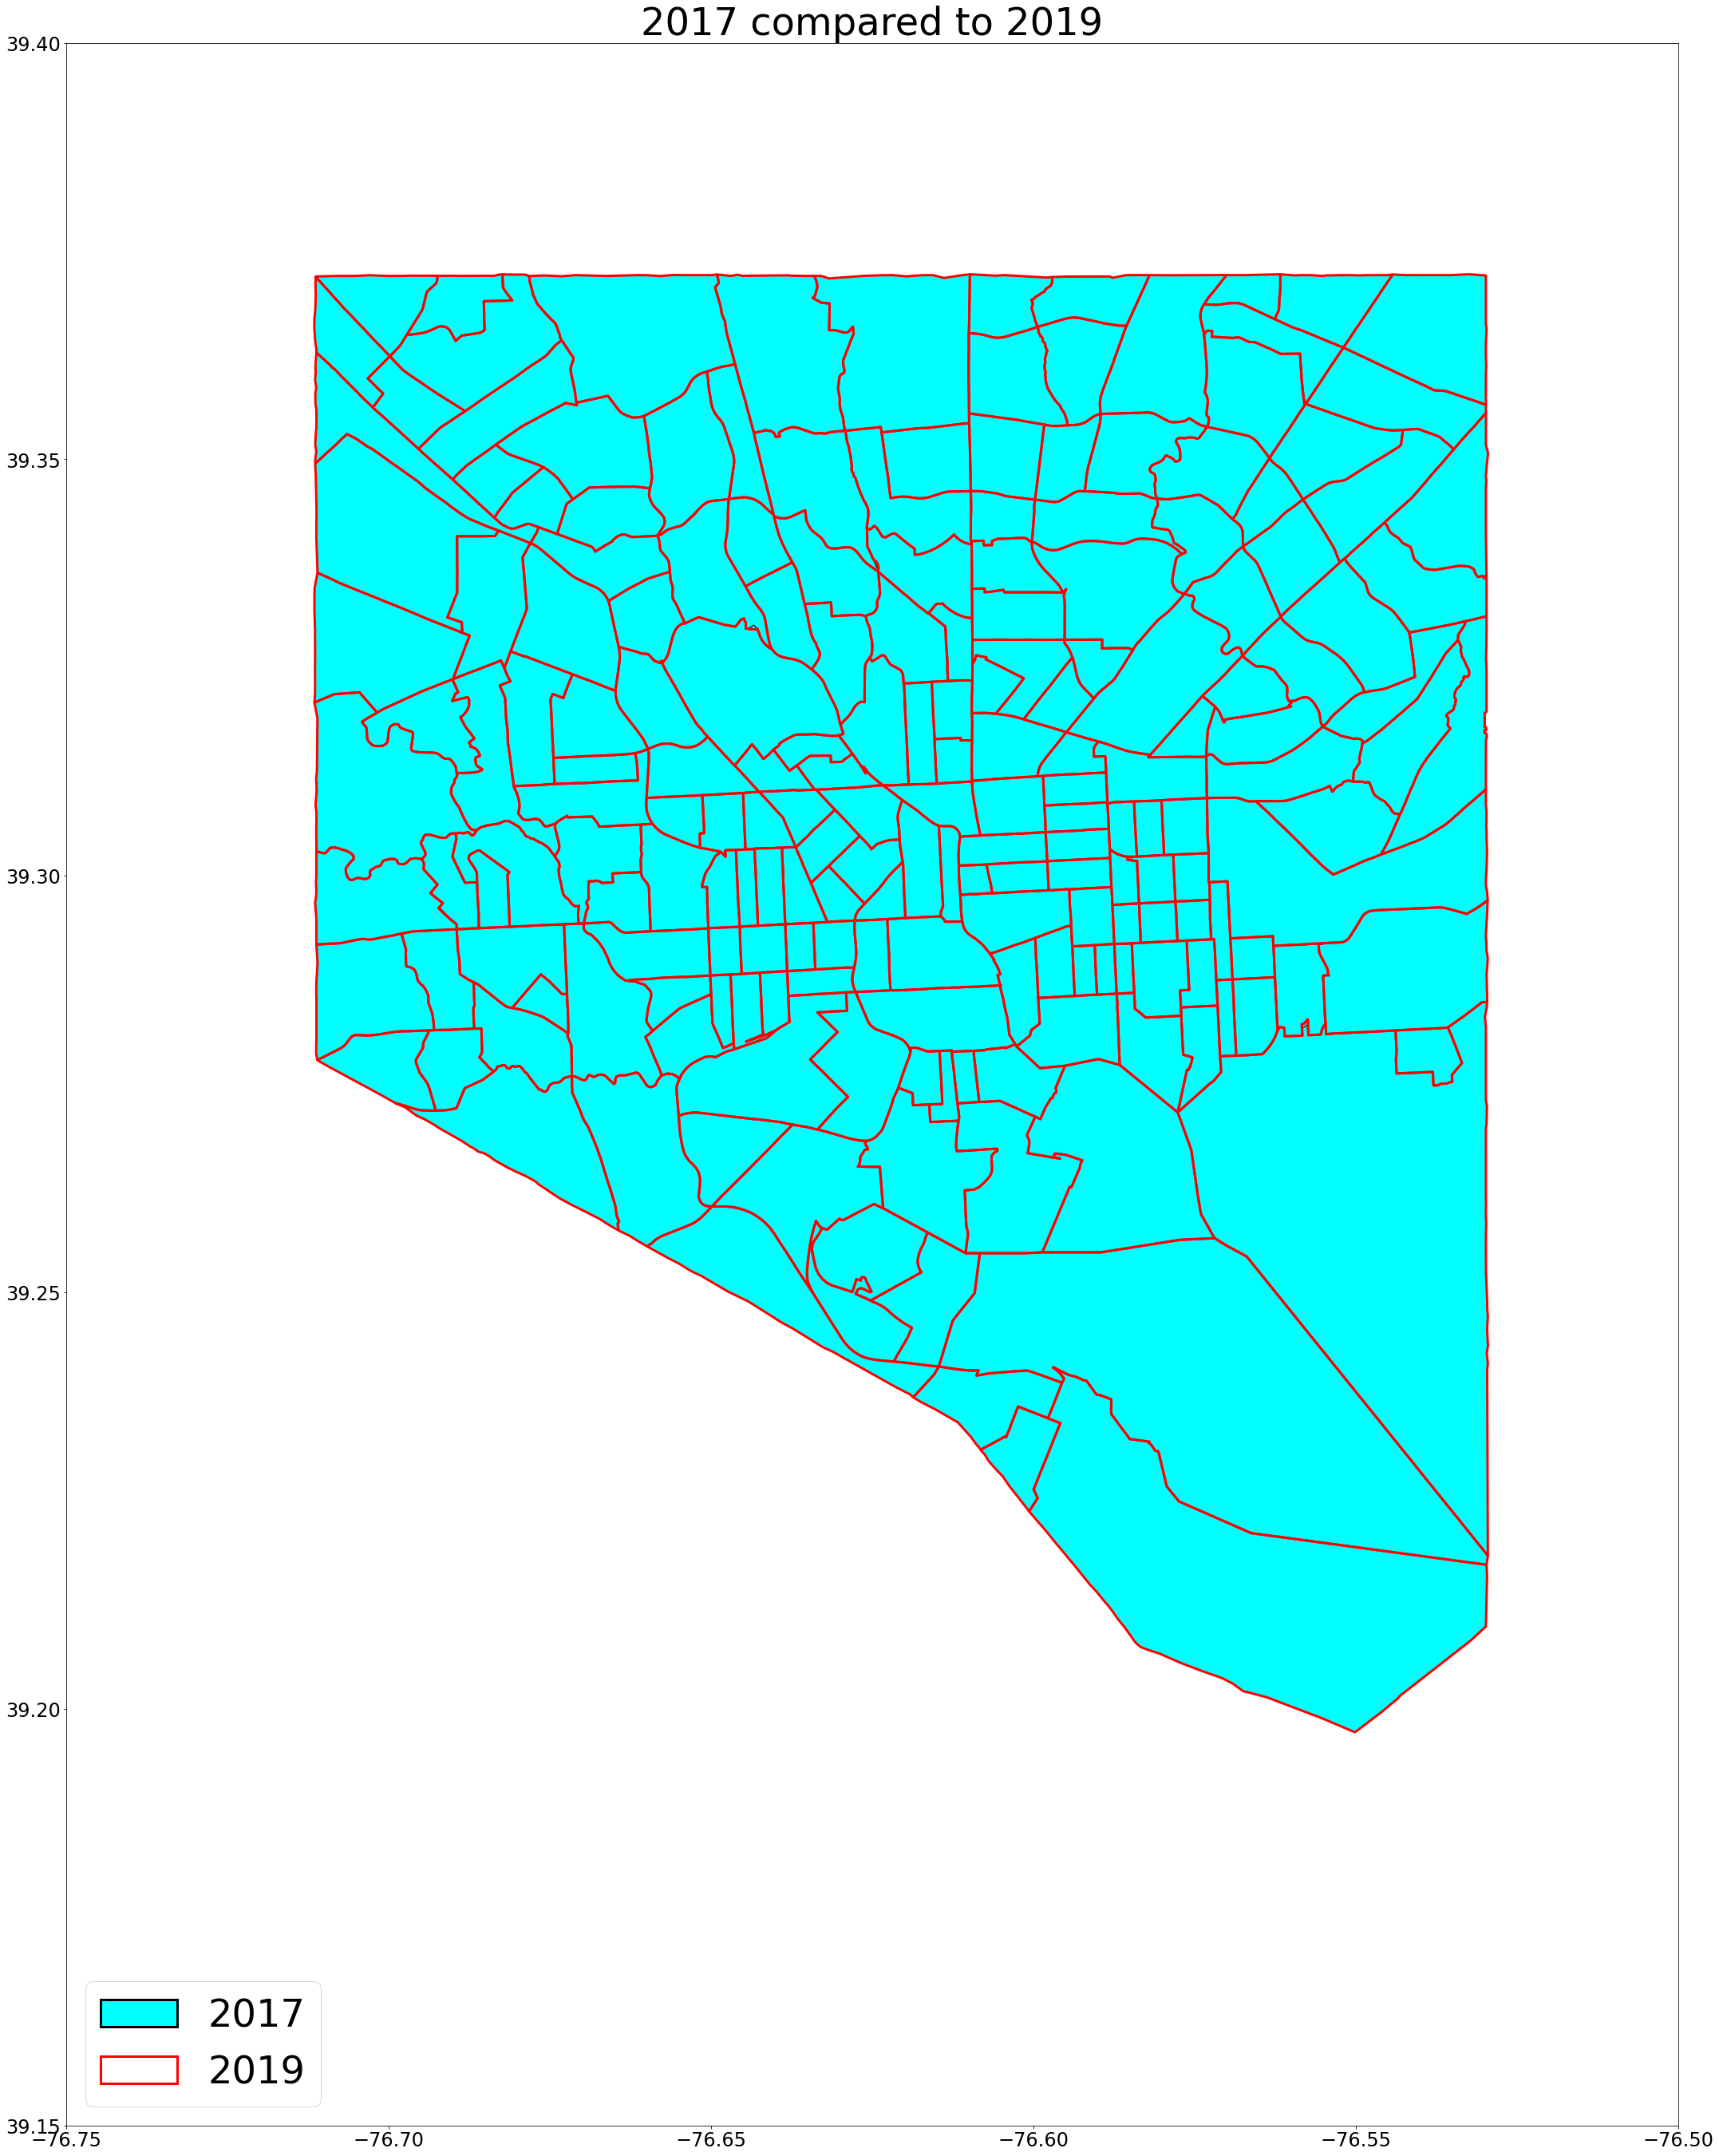

Checked consistency of 600 tract-years in 0 minutes 3 seconds!


In [5]:
s = time.time()
test_year = 2017
test_color = 'cyan'
control_year = 2019
control_edge_color = 'red'

legend_location = 'lower left'

# print('getting from backup...')
# city_tracts_years_gdf = city_tracts_years_gdf_bk


counties_list = city_tracts_years_gdf['county'].drop_duplicates().tolist()

#print('{0:} covers {1:,.0f} county...'.format(city, len(counties_list)))
#city_tracts_years_gdf.head(1).T
for x in counties_list:
    print('County {0:,.0f} contains {1:,.0f} tract-years:'.format(x, len(city_tracts_years_gdf.reset_index()[city_tracts_years_gdf.reset_index()['county'] == x])))
    for i in years:
        print('{0:.0f}: {1:,.0f} tracts'.format(
            i, 
            len(city_tracts_years_gdf.reset_index()[
                (city_tracts_years_gdf.reset_index()['county'] == x) 
                & (city_tracts_years_gdf.reset_index()['year'] == i)])
        ))
        county_x_year_control_census_tracts_list = city_tracts_years_gdf.reset_index()[
            (city_tracts_years_gdf.reset_index()['county'] == x) 
            & (city_tracts_years_gdf.reset_index()['year'] == control_year)
        ]['NAME'].tolist()
        
        county_x_year_i_census_tracts_list = city_tracts_years_gdf.reset_index()[
            (city_tracts_years_gdf.reset_index()['county'] == x) 
            & (city_tracts_years_gdf.reset_index()['year'] == i)
        ]['NAME'].tolist()
        #print(county_x_year_i_census_tracts_list)
        
        new_census_tracts = []
        missing_census_tracts = []
        
        for n in county_x_year_i_census_tracts_list:
            if (n not in county_x_year_control_census_tracts_list):
                new_census_tracts.append(n)
            for p in county_x_year_control_census_tracts_list:
                if (p not in county_x_year_i_census_tracts_list):
                    missing_census_tracts.append(n)
        for y in new_census_tracts:
            print('Found census tract in {0:.0f} that is not present in 2018: {1:}'.format(i,y))
        for z in missing_census_tracts:
            print('Found census tract from 2018 that was not present in {0:.0f}: {1:}'.format(i,z))
        if (len(new_census_tracts) + len(missing_census_tracts) == 0):
            print('\tAll census tracts match!')
        else:
            print('\n')
legend_list = []
if (check_tract_consistency):
    print('Plotting tracts for potential border differences...')
    fig, ax = plt.subplots(1,1, figsize=(48*scale,48*scale))
    
    city_tracts_years_gdf.xs(test_year, level='year').plot(ax=ax, color=test_color, edgecolor='black')
    city_tracts_years_gdf.xs(control_year, level='year').plot(ax=ax, color='none', edgecolor=control_edge_color, lw=3*scale)
    
    
    legend_list.append(mpatches.Patch(facecolor=test_color, edgecolor='black', lw=3*scale, label='{0:}'.format(test_year)))
    legend_list.append(mpatches.Patch(facecolor='none', edgecolor=control_edge_color, lw=3*scale, label='{0:}'.format(control_year)))
    
    if (show_water):
        print('\treading water files...')
        water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/".format(show_year)
        water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(show_year,thestate) in x) and (x[-3:] == 'shp')]
        water_gdf = geopandas.GeoDataFrame()
        for i in range(0, len(water_files)):
            if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
                print('\t\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
            water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
        water_gdf.plot(ax=ax, color='blue')
    
#     # #city_tracts_years_gdf.loc[[2012, 35, 1711.03]].geometry.plot()#.plot(color='red')
#     for ix, thisrow in city_tracts_years_gdf.xs(otheryear, level=-1).iterrows():
#         if (ix[1] in new_census_tracts):
#             annotator = ix[1]
#             ax.annotate(annotator, 
#                        xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                        xytext=(thisrow.geometry.centroid.x,#+0.01*np.random.rand(), 
#                                thisrow.geometry.centroid.y),#+0.01*np.random.rand()), 
#                        backgroundcolor = 'white', horizontalalignment='center', verticalalignment='center',
#                        fontsize=24*scale)

    
    ax.legend(handles=legend_list, fontsize=48*scale, loc=legend_location)
    plt.title('{0:.0f} compared to {1:.0f}'.format(test_year, control_year), fontsize=48*scale)
    ax.tick_params(axis='both', which='major', labelsize=24*scale)
    plt.xlim([plotlimits['W'], plotlimits['E']])
    plt.ylim([plotlimits['S'], plotlimits['N']])

    plt.show()

e = time.time()
g = g + (e-s)
print('Checked consistency of {0:,.0f} tract-years in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(city_tracts_years_gdf), np.floor((e-s)/60), (e-s)%60))


In [6]:
# print('finding tracts with different centroids and/or areas...')

# centroid_tolerance_meters = 100
# area_tolerance_square__meters = 1000

# tracts_to_label = []
# cnt = 1
# for this_oneyear_index in city_tracts_years_gdf.xs(oneyear, level=-1).index.values:
#     if (np.mod(cnt-1,50) == 0):
#         print('Checking tract {0:.0f} of {1:.0f}...'.format(cnt, len(city_tracts_years_gdf.xs(oneyear, level=-1).index.values)))
#     centroid_offset_meters = city_tracts_years_gdf.xs(oneyear, level=-1).to_crs(epsg=2272).loc[this_oneyear_index].geometry.centroid.distance(city_tracts_years_gdf.xs(otheryear, level=-1).to_crs(epsg=2272).loc[this_oneyear_index].geometry.centroid)
#     area_difference_square_meters = np.abs(city_tracts_years_gdf.xs(oneyear, level=-1).to_crs(epsg=2272).loc[this_oneyear_index].geometry.area - city_tracts_years_gdf.xs(otheryear, level=-1).to_crs(epsg=2272).loc[this_oneyear_index].geometry.area)
#     #print(this_oneyear_index)
#     if ((centroid_offset_meters >= centroid_tolerance_meters) | (area_difference_square_meters >= area_tolerance_square__meters)):
#         print('\tCounty {0:} tract {1:} ({2:} vs. {3:}): centroid offset is {4:.1f} meters; area difference is {5:,.0f} square meters..'.format(this_oneyear_index[0], this_oneyear_index[1], oneyear, otheryear, centroid_offset_meters, area_difference_square_meters))
#     cnt = cnt + 1
# #     oneyear_tract_centroid = city_tracts_years_gdf.xs(oneyear, level=-1).loc[this_oneyear_index].geometry.centroid
# #     otheryear_tract_centroid = city_tracts_years_gdf.xs(otheryear, level=-1).loc[this_oneyear_index].geometry.centroid
# #     oneyear_tract_area = city_tracts_years_gdf.xs(oneyear, level=-1).loc[this_oneyear_index].geometry.area
# #     otheryear_tract_area = city_tracts_years_gdf.xs(otheryear, level=-1).loc[this_oneyear_index].geometry.area
# #     if ((oneyear_tract_centroid.distance(otheryear_tract_centroid) > centroid_tolerance) & (np.abs(oneyear_tract_area - otheryear_tract_area) > area_tolerance)):
# #         if (this_oneyear_index not in tracts_to_label):
# #             tracts_to_label.append(this_oneyear_index)

In [7]:



# for this_oneyear_index in tracts_to_label:
#     print('county {0:.0f}, tract {1:.2f}:'.format(this_oneyear_index[0],this_oneyear_index[1]))
#     print('\tcentroids differ by {0:.2e}'.format(city_tracts_years_gdf.xs(oneyear, level=-1).loc[this_oneyear_index].geometry.centroid.distance(city_tracts_years_gdf.xs(otheryear, level=-1).loc[this_oneyear_index].geometry.centroid)))
#     print('\tareas differ by {0:.2e}'.format(np.abs(city_tracts_years_gdf.xs(oneyear, level=-1).loc[this_oneyear_index].geometry.area - city_tracts_years_gdf.xs(otheryear, level=-1).loc[this_oneyear_index].geometry.area)))
#     print('\n')
    
    
    
    
# fig, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))
# city_tracts_years_gdf.xs(oneyear, level=-1).plot(ax=ax, color='none', edgecolor='black')
# city_tracts_years_gdf.xs(otheryear, level=-1).plot(ax=ax, color='none', edgecolor='red')
# # if (show_water):
# #     print('reading water files...')
# #     water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/".format(show_year)
# #     water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(show_year,thestate) in x) and (x[-3:] == 'shp')]
# #     water_gdf = geopandas.GeoDataFrame()
# #     for i in range(0, len(water_files)):
# #         if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
# #             print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
# #     water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
# #     water_gdf.plot(ax=ax)

# # for ix, thisrow in city_tracts_years_gdf.xs(oneyear, level=-1).loc[tracts_to_label].iterrows():
# #     annotator = ix
# #     ax.annotate(annotator, 
# #                 xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                 xytext=(thisrow.geometry.centroid.x,#+0.01*np.random.rand(), 
# #                         thisrow.geometry.centroid.y),#+0.01*np.random.rand()), 
# #                 backgroundcolor = 'white', horizontalalignment='center', verticalalignment='center',
# #                 fontsize=24*scale)

# plt.xlim([plotlimits['W'], plotlimits['E']])
# plt.ylim([plotlimits['S'], plotlimits['N']])
# plt.title('{0:.0f} (black) vs {1:.0f} (red)'.format(oneyear, otheryear), size=48*scale)

# plt.show()


# Get geo-aggregated loans for this city

and join the tract data onto the loans data

In [8]:
s = time.time()
# print('getting from backup...')
# city_tracts_years_gdf = city_tracts_years_gdf_bk

print('reading nationwide data...')
agg_loans_all_df = pandas.read_csv(data_dir+'agg_loans.csv', encoding='utf-8', low_memory=False, index_col='rownumber', keep_default_na=False)
e = time.time()
print('Read {0:,.0f} nationwide tract-years in {1:,.0f} seconds...'.format(len(agg_loans_all_df), e-s))

# Keep only business loans
agg_loans_all_df = agg_loans_all_df[agg_loans_all_df['loan_type'] == 4]
# Keep only loan originations
agg_loans_all_df = agg_loans_all_df[agg_loans_all_df['action_taken_type'] == 1]
# Keep only this state
agg_loans_all_df = agg_loans_all_df[agg_loans_all_df['state'] == thestate]


#agg_loans_all_df.apply(lambda row: '{0:02d}'.format(row['state'], axis=1))
#agg_loans_all_df = agg_loans_all_df.assign(zzz = '{0:,.0f}{1:,.0f}'.format(agg_loans_all_df
agg_loans_all_df = agg_loans_all_df.assign(
    GEOID = agg_loans_all_df.apply(lambda row: '14000US{0:02d}{1:03d}{2:04d}{3:02d}'.format(
        row['state'], 
        row['county'], 
        int(str(row['census_tract'])[0:str(row['census_tract']).find('.')]),
        int(str(row['census_tract'])[str(row['census_tract']).find('.')+1:])
    ), axis=1))
agg_loans_all_df = agg_loans_all_df.rename(columns={'activity_year': 'year'})
agg_loans_all_df = agg_loans_all_df.set_index(['GEOID','year'])



data_gdf = city_tracts_years_gdf.join(agg_loans_all_df[[x for x in agg_loans_all_df.columns if x not in city_tracts_years_gdf.columns]], how='left')
# # data_gdf[['county_geodata','county_loandata']]

print('converting columns to numeric...')
numeric_columns = []
numeric_columns += ['nLoans1', 'amtLoans1', 'nLoans100k', 'amtLoans100k']
numeric_columns += ['nLoans250k', 'amtLoans250k', 'nLoansToSmallest', 'amtLoansToSmallest']

# for x in numeric_columns:
#     data_gdf.loc[:, x] = pandas.to_numeric(x, errors='coerce')
print('calculating total loans...')
data_gdf = data_gdf.assign(nLoans = data_gdf['nLoans1'] + data_gdf['nLoans100k'] + data_gdf['nLoans250k'])
data_gdf = data_gdf.assign(amtLoans = data_gdf['amtLoans1'] + data_gdf['amtLoans100k'] + data_gdf['amtLoans250k'])
e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(data_gdf), e-s))


reading nationwide data...
Read 3,046,200 nationwide tract-years in 10 seconds...
converting columns to numeric...
calculating total loans...
Kept 600 tract-years in 13 seconds!


## Add income groups, CRA levels, working loans for each tract-year

In [9]:
s = time.time()

# print('getting from backup...')
# data_gdf = data_gdf_bk

print('looking up income group names from income_group_total...')

data_gdf = data_gdf.rename(columns = {'income_group_total': 'income_group_code'})
data_gdf = data_gdf.assign(income_group = np.nan)

data_gdf.loc[data_gdf['income_group_code'] == 1, 'income_group'] = '< 10% of Median Family Income (MFI)'
data_gdf.loc[data_gdf['income_group_code'] == 2, 'income_group'] = '10% to 20% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 3, 'income_group'] = '20% to 30% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 4, 'income_group'] = '30% to 40% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 5, 'income_group'] = '40% to 50% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 6, 'income_group'] = '50% to 60% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 7, 'income_group'] = '60% to 70% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 8, 'income_group'] = '70% to 80% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 9, 'income_group'] = '80% to 90% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 10, 'income_group'] = '90% to 100% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 11, 'income_group'] = '100% to 110% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 12, 'income_group'] = '110% to 120% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 13, 'income_group'] = '> 120% of MFI'
data_gdf.loc[data_gdf['income_group_code'] == 14, 'income_group'] = 'unknown'

print('Adding CRA income levels (low/moderate/middle/upper/unknown)...')
# Get levels (low, moderate, middle, upper)
data_gdf = data_gdf.assign(cra_level = np.nan)
data_gdf.loc[(data_gdf['income_group_code'] >= 1) & (data_gdf['income_group_code'] <= 5), 'cra_level'] = 'low'
data_gdf.loc[(data_gdf['income_group_code'] >= 6) & (data_gdf['income_group_code'] <= 8), 'cra_level'] = 'moderate'
data_gdf.loc[(data_gdf['income_group_code'] >= 9) & (data_gdf['income_group_code'] <= 12), 'cra_level'] = 'middle'
data_gdf.loc[(data_gdf['income_group_code'] == 13), 'cra_level'] = 'upper'
data_gdf.loc[(data_gdf['income_group_code'] == 14), 'cra_level'] = 'unknown'

print('Getting CRA income levels for tracts where only CRA level was reported...')
data_gdf.loc[data_gdf['income_group_code'] == 101, 'cra_level'] = 'low'
data_gdf.loc[data_gdf['income_group_code'] == 102, 'cra_level'] = 'moderate'
data_gdf.loc[data_gdf['income_group_code'] == 103, 'cra_level'] = 'middle'
data_gdf.loc[data_gdf['income_group_code'] == 104, 'cra_level'] = 'upper'
data_gdf.loc[data_gdf['income_group_code'] == 105, 'cra_level'] = 'unknown'

print('calculating working loans...')
data_gdf = data_gdf.assign(avgSmallLoan = data_gdf['amtLoans1'] / data_gdf['nLoans1'])

data_gdf = data_gdf.assign(nWorkingLoans = 0)
data_gdf.loc[data_gdf['avgSmallLoan'] < 10000, 
                           'nWorkingLoans'] = data_gdf['nLoans'][data_gdf['avgSmallLoan'] < 10000] - data_gdf['nLoans1'][data_gdf['avgSmallLoan'] < 10000]
data_gdf.loc[data_gdf['avgSmallLoan'] >= 10000, 
                           'nWorkingLoans'] = data_gdf['nLoans'][data_gdf['avgSmallLoan'] >= 10000]

data_gdf = data_gdf.assign(amtWorkingLoans = 0)
data_gdf.loc[data_gdf['avgSmallLoan'] < 10000, 
                           'amtWorkingLoans'] = data_gdf['amtLoans'][data_gdf['avgSmallLoan'] < 10000] - data_gdf['amtLoans1'][data_gdf['avgSmallLoan'] < 10000]
data_gdf.loc[data_gdf['avgSmallLoan'] >= 10000, 
                           'amtWorkingLoans'] = data_gdf['amtLoans'][data_gdf['avgSmallLoan'] >= 10000]

e = time.time()
g = g + (e-s)

# print('backing up...')
# data_gdf_bk = data_gdf
print('Kept {0:,.0f} tract-years in {1:} in {2:,.2f} seconds!'.format(len(data_gdf), city, e-s))
print(data_gdf.groupby('income_group').size())
print(data_gdf.groupby('cra_level').size())
#print('\n')
#data_gdf[data_gdf['cra_level'] == 'unknown']


looking up income group names from income_group_total...
Adding CRA income levels (low/moderate/middle/upper/unknown)...
Getting CRA income levels for tracts where only CRA level was reported...
calculating working loans...
Kept 600 tract-years in Baltimore in 0.10 seconds!
income_group
10% to 20% of MFI       12
100% to 110% of MFI     15
110% to 120% of MFI      9
20% to 30% of MFI       33
30% to 40% of MFI       87
40% to 50% of MFI      117
50% to 60% of MFI      114
60% to 70% of MFI       48
70% to 80% of MFI       33
80% to 90% of MFI       36
90% to 100% of MFI      24
> 120% of MFI           57
unknown                 12
dtype: int64
cra_level
low         249
middle       84
moderate    195
unknown      12
upper        57
dtype: int64


## Connect to jobs data

### Get raw jobs table

In [10]:
s = time.time()

print('reading state jobs data for {0:}...'.format(state_abbrev.upper()))

statejobfiles = sorted([jobs_dir+x for x in os.listdir(jobs_dir) if '{0:}'.format(state_abbrev) in x and '{0:}.'.format(state_abbrev) in x])
#print(statejobfiles)
state_raw_jobs_df = pandas.DataFrame()
for thisfile in statejobfiles:
    print('Reading {0:}...'.format(thisfile))
    state_raw_jobs_df = pandas.concat((state_raw_jobs_df,pandas.read_csv(thisfile, index_col='rownumber', low_memory=False, keep_default_na=False)), axis=0)

    
print('constructing GEOIDs...')
if (thestate < 10):
    state_raw_jobs_df = state_raw_jobs_df.assign(GEOID = state_raw_jobs_df['w_geocode'].apply(lambda x: '14000US{0:02d}{1:}'.format(thestate,str(x)[1:10])))
else:
    state_raw_jobs_df = state_raw_jobs_df.assign(GEOID = state_raw_jobs_df['w_geocode'].apply(lambda x: '14000US{0:02d}{1:}'.format(thestate,str(x)[2:11])))

    
print('selecting raw jobs from {0:}...'.format(city))

city_raw_jobs_df = state_raw_jobs_df[state_raw_jobs_df['GEOID'].isin(data_gdf.index.get_level_values('GEOID').tolist())]

# print('backing up...')
# city_raw_jobs_df_bk = city_raw_jobs_df

e = time.time()
g = g + (e-s)
print('Read jobs for {0:,.0f} block-group-years in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(city_raw_jobs_df), city, np.floor((e-s)/60), np.floor((e-s)%60)))



reading state jobs data for MD...
Reading /home/idies/workspace/Temporary/raddick/cra_scratch/lodes_wac/jobs_data_md.csv...
constructing GEOIDs...
selecting raw jobs from Baltimore...
Read jobs for 2,004,138 block-group-years in Baltimore in 4 minutes 43 seconds!


# Sum jobs over census tracts

In [11]:
# print('getting from backup...')
# city_raw_jobs_df_bk = city_raw_jobs_df

sum_columns = [x for x in city_raw_jobs_df.columns if x[0] == 'C']

city_jobs_df = pandas.DataFrame(data=None, columns=sum_columns)

print('summing into census tracts...')
for x in sum_columns:
#    print('summing {0:} across census tracts...'.format(x))
    city_jobs_df.loc[:, x] = city_raw_jobs_df.groupby(['GEOID', 'year'])[x].sum()

print('copying 2018 jobs into 2019...')
city_jobs_2019_df = city_jobs_df.xs(2018, level='year').reset_index()
city_jobs_2019_df = city_jobs_2019_df.assign(year = 2019).set_index(['GEOID', 'year'])
city_jobs_df = pandas.concat((city_jobs_df, city_jobs_2019_df), axis=0)
city_jobs_df

print('getting columns we want...')

jobs_metadata_df = pandas.read_csv(code_lookup_dir+'wac_jobs_metadata.csv', encoding='utf-8', index_col='varnum')
jobs_metadata_df = jobs_metadata_df.set_index('variable')

jobs_columns = ['C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03', 'CNS01']
jobs_columns += ['CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08']
jobs_columns += ['CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15']
jobs_columns += ['CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02']
jobs_columns += ['CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02']
jobs_columns += ['CD03', 'CD04', 'CS01', 'CS02', 'CFA01', 'CFA02', 'CFA03']
jobs_columns += ['CFA04', 'CFA05', 'CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

#for x in baltimore_agg_loans_df[jobs_columns].columns:
#    print('variable: {0:}\t\tdescription:{1:}'.format(x, jobs_metadata_df['description'][jobs_metadata_df.index == x].tolist()[0]))


#city_jobs_df = city_jobs_df.rename(columns={'C000': 'totaljobs', 'CFS01': 'sbjobs'})
jobs_columns_we_want = ['C000', 'CFS01']

# print('backing up...')
# city_jobs_df_bk = city_jobs_df

e = time.time()
g = g + (e-s)
for x in city_jobs_df[jobs_columns_we_want].columns:
    print('variable: {0:}\t\tdescription:{1:}'.format(x, jobs_metadata_df['description'][jobs_metadata_df.index == x].tolist()[0]))





summing into census tracts...
copying 2018 jobs into 2019...
getting columns we want...
variable: C000		description:Total number of jobs
variable: CFS01		description:Number of jobs for workers at firms with Firm Size: 0-19 Employees


### Merge jobs with rest of data

In [12]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk
# city_jobs_df = city_jobs_df_bk


#data_gdf.head(1).T #['COUNTYFP','NAME','year']
data_gdf = data_gdf.join(city_jobs_df)

# for x in jobs_columns_we_want:
#     data_gdf.loc[:, x] = data_gdf[x].fillna(0)

data_gdf = data_gdf.sort_index()

print('done')

e = time.time()
g = g + (e-s)
print('Added jobs data for {0:,.0f} tract-years!'.format(len(data_gdf[data_gdf['CFS01'].notnull()])))

# print('backing up...')
# data_gdf_bk = data_gdf

data_gdf.tail(1).T

done
Added jobs data for 600 tract-years!


GEOID,14000US24510280500
year,2019
STATEFP,24
county,510
census_tract,2805
NAME,2805
NAMELSAD,Census Tract 2805
...,...
CFS01,0
CFS02,0
CFS03,0


### Get loans per job

In [13]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk
#sbjobs_column = jobs_varnames_df[jobs_varnames_df['description'].apply(lambda x: '0-19' in x)].index.values[0]
#loans_columns = []
#data_gdf[sbjobs_column]
print('Calulating loans per job (total and with firm size 0-19)...')

data_gdf = data_gdf.assign(nLoans1_per_totaljob = data_gdf['nLoans1'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtLoans1_per_totaljob = data_gdf['amtLoans1'] / data_gdf['C000'])
data_gdf = data_gdf.assign(nLoans100k_per_totaljob = data_gdf['nLoans100k'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtLoans100k_per_totaljob = data_gdf['amtLoans100k'] / data_gdf['C000'])
data_gdf = data_gdf.assign(nLoans250k_per_totaljob = data_gdf['nLoans250k'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtLoans250k_per_totaljob = data_gdf['amtLoans250k'] / data_gdf['C000'])
data_gdf = data_gdf.assign(nLoansToSmallest_per_totaljob = data_gdf['nLoansToSmallest'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtLoansToSmallest_per_totaljob = data_gdf['amtLoansToSmallest'] / data_gdf['C000'])
data_gdf = data_gdf.assign(nLoans_per_totaljob = data_gdf['nLoans'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtLoans_per_totaljob = data_gdf['amtLoans'] / data_gdf['C000'])
data_gdf = data_gdf.assign(nWorkingLoans_per_totaljob = data_gdf['nWorkingLoans'] / data_gdf['C000'])
data_gdf = data_gdf.assign(amtWorkingLoans_per_totaljob = data_gdf['amtWorkingLoans'] / data_gdf['C000'])

data_gdf = data_gdf.assign(nLoans1_per_sbjob = data_gdf['nLoans1'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtLoans1_per_sbjob = data_gdf['amtLoans1'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(nLoans100k_per_sbjob = data_gdf['nLoans100k'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtLoans100k_per_sbjob = data_gdf['amtLoans100k'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(nLoans250k_per_sbjob = data_gdf['nLoans250k'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtLoans250k_per_sbjob = data_gdf['amtLoans250k'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(nLoansToSmallest_per_sbjob = data_gdf['nLoansToSmallest'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtLoansToSmallest_per_sbjob = data_gdf['amtLoansToSmallest'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(nLoans_per_sbjob = data_gdf['nLoans'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtLoans_per_sbjob = data_gdf['amtLoans'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(nWorkingLoans_per_sbjob = data_gdf['nWorkingLoans'] / data_gdf['CFS01'])
data_gdf = data_gdf.assign(amtWorkingLoans_per_sbjob = data_gdf['amtWorkingLoans'] / data_gdf['CFS01'])


per_job_columns = ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob', 'nLoans100k_per_totaljob']
per_job_columns += ['amtLoans100k_per_totaljob', 'nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob']
per_job_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob']
per_job_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob', 'nWorkingLoans_per_totaljob']
per_job_columns += ['amtWorkingLoans_per_totaljob', 'nLoans1_per_sbjob', 'amtLoans1_per_sbjob']
per_job_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob', 'nLoans250k_per_sbjob']
per_job_columns += ['amtLoans250k_per_sbjob', 'nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob']
per_job_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob', 'nWorkingLoans_per_sbjob']
per_job_columns += ['amtWorkingLoans_per_sbjob']


print('recoding zero/zero values to zero and infinite values to NaN...')
for x in data_gdf[per_job_columns]:
    data_gdf.loc[:, x] = data_gdf[x].fillna(0)
    data_gdf.loc[data_gdf[x] == np.inf, x] = np.nan

# print('backing up...')
# data_gdf_bk = data_gdf

e = time.time()
g = g + (e-s)
print('Done in {0:,.1f} seconds!'.format(e-s)) 
# data_gdf[(data_gdf['nWorkingLoans'] == 0) | (data_gdf['CFS01'] == 0)][
#     ['nWorkingLoans', 'amtWorkingLoans', 'C000', 'CFS01', 'nWorkingLoans_per_totaljob', 'amtWorkingLoans_per_totaljob', 'nWorkingLoans_per_sbjob', 'amtWorkingLoans_per_sbjob']
# ].sample(4).T


Calulating loans per job (total and with firm size 0-19)...
recoding zero/zero values to zero and infinite values to NaN...
Done in 0.2 seconds!


## Get ACS data

In [14]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk

acs5_estimates_df = pandas.DataFrame()
acs5_margins_of_error_df = pandas.DataFrame()

print('Getting ACS 5-year census data...')


for thisyear in years:
    print('\t{0:.0f} estimates...'.format(thisyear))
    acs5_estimates_this_year_df = pandas.read_csv(acs5_basedir+'{0:.0f}/estimates/estimates_acs{0:.0f}_tract_for_cra_analysis_mac.csv'.format(thisyear), low_memory=False, encoding='utf-8', index_col='GEOID')
    acs5_estimates_this_year_df = acs5_estimates_this_year_df.drop([x for x in acs5_estimates_this_year_df.columns.tolist() if 'unnamed' in x.lower()], axis=1)

    acs5_estimates_this_year_df = acs5_estimates_this_year_df.assign(year = thisyear)
    acs5_estimates_df = pandas.concat((acs5_estimates_df, acs5_estimates_this_year_df), axis=0, sort=False)
        
    print('\t{0:.0f} margins of error...'.format(thisyear))
    acs5_margins_of_error_this_year_df = pandas.read_csv(acs5_basedir+'{0:.0f}/margins_of_error/margins_of_error_acs{0:.0f}_tract_for_cra_analysis_mac.csv'.format(thisyear), low_memory=False, encoding='utf-8', index_col='GEOID')
    if (thisyear <= 2014):
        acs5_margins_of_error_this_year_df = acs5_margins_of_error_this_year_df.drop([x for x in acs5_margins_of_error_this_year_df.columns.tolist() if 'unnamed' in x.lower()], axis=1)
    acs5_margins_of_error_this_year_df = acs5_margins_of_error_this_year_df.assign(year = thisyear)
    acs5_margins_of_error_df = pandas.concat((acs5_margins_of_error_df, acs5_margins_of_error_this_year_df), axis=0, sort=False)

    
    
print('discarding block groups, keeping census tracts...')
acs5_estimates_df = acs5_estimates_df.reset_index()
acs5_margins_of_error_df = acs5_margins_of_error_df.reset_index()

acs5_estimates_df = acs5_estimates_df[acs5_estimates_df['GEOID'].apply(lambda x: x[0:3] == '140')]
acs5_margins_of_error_df = acs5_margins_of_error_df[acs5_margins_of_error_df['GEOID'].apply(lambda x: x[0:3] == '140')]


print('converting to numeric...')
for x in ['B08013_001', 'B19013_001', 'B19013A_001', 'B19013B_001', 'B19113_001', 'B25077_001', 'B25035_001']:
    acs5_estimates_df.loc[:, x] = pandas.to_numeric(acs5_estimates_df[x], errors='coerce')
    acs5_margins_of_error_df.loc[:, x] = pandas.to_numeric(acs5_margins_of_error_df[x], errors='coerce')

print('renaming error columns...')
orig_column_names = acs5_margins_of_error_df.columns.tolist()[6:-6]
err_column_names = []
for x in orig_column_names:
    err_column_names.append(x+'_err')
acs5_margins_of_error_df.columns = acs5_margins_of_error_df.columns.tolist()[0:6]+err_column_names+acs5_margins_of_error_df.columns.tolist()[-6:]

print('joining to the rest of the data...')
acs5_estimates_df = acs5_estimates_df.set_index(['GEOID', 'year'])
acs5_margins_of_error_df = acs5_margins_of_error_df.set_index(['GEOID', 'year'])


data_gdf = data_gdf.join(acs5_estimates_df[acs5_estimates_df.index.isin(data_gdf.index)][acs5_estimates_df.columns.tolist()[:-5]+acs5_estimates_df.columns.tolist()[-1:]], how='left', lsuffix='_loans_jobs', rsuffix='_acs5')
data_gdf = data_gdf.join(acs5_margins_of_error_df[acs5_margins_of_error_df.index.isin(data_gdf.index)][acs5_margins_of_error_df.columns.tolist()[6:-3]+acs5_margins_of_error_df.columns.tolist()[-1:]], how='left', lsuffix='_loans_jobs', rsuffix='_acs5')

# print('backing up...')
# data_gdf_bk = data_gdf
e = time.time()
g = g + (e-s)

print('{0:}: Kept {1:,.0f} tract-years in {2:,.0f} minutes {3:.0f} seconds!'.format(city, len(data_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))


Getting ACS 5-year census data...
	2019 estimates...
	2019 margins of error...
	2018 estimates...
	2018 margins of error...
	2017 estimates...
	2017 margins of error...
discarding block groups, keeping census tracts...
converting to numeric...
renaming error columns...
joining to the rest of the data...
Baltimore: Kept 600 tract-years in 0 minutes 30 seconds!


### Calculate composite demographic columns

In [15]:
acs5_columns = [x for x in data_gdf.columns.tolist() if x[0] == 'B']
acs5_metadata_df = pandas.read_csv(acs5_basedir+'2018/variables/variables_acs_5yr_all.csv', encoding='utf-8', low_memory=False, index_col='rownumber')

acs5_metadata_df[acs5_metadata_df['variable'].isin(acs5_columns)][['variable','description']][30:60]


,variable,description
rownumber,,
47,B01001_040,SEX BY AGE%Total population%Total%Female%50 to 54 years
48,B01001_041,SEX BY AGE%Total population%Total%Female%55 to 59 years
49,B01001_042,SEX BY AGE%Total population%Total%Female%60 and 61 years
50,B01001_043,SEX BY AGE%Total population%Total%Female%62 to 64 years
51,B01001_044,SEX BY AGE%Total population%Total%Female%65 and 66 years
52,B01001_045,SEX BY AGE%Total population%Total%Female%67 to 69 years
53,B01001_046,SEX BY AGE%Total population%Total%Female%70 to 74 years
54,B01001_047,SEX BY AGE%Total population%Total%Female%75 to 79 years
55,B01001_048,SEX BY AGE%Total population%Total%Female%80 to 84 years


In [16]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk

print('\ncalculating and renaming estimates columns for IVs...')

if (debug >= 1):
    print('population 25 and older with bachelors degree or higher (B15003_022 t.e.m. B15003_025...')
h = data_gdf['B15003_022'] + data_gdf['B15003_023'] + data_gdf['B15003_024']  + data_gdf['B15003_025']
data_gdf = data_gdf.assign(educated = pandas.to_numeric(h, errors='coerce'))

if (debug >= 1):
    print('...population 25 years and older...')
data_gdf = data_gdf.rename(columns={'B15003_001': 'pop_25plus'})


if (debug >= 1):
    print('...householder sex & race, unempoyment, poverty, household type, home value, home age, travel time...')
data_gdf = data_gdf.rename(columns = {  
    'B11001_006': 'female_householders',
    'B11001A_001': 'white_householders',
    'B11001B_001': 'black_householders',
    'B23025_005': 'unemployed_16plus',
    'B17001_002': 'poverty_past_12_months',
    'B25077_001': 'median_home_value',
    'B25035_001': 'median_year_built',
})

if (debug >= 1):
    print('...race, owner-occupied units, mfi, vacants...')
data_gdf = data_gdf.rename(columns = {    
    'B02001_002': 'pop_white',
    'B02001_003': 'pop_black',
    'B25003_002': 'owner_occ_housing_units',
    'B19113_001': 'mfi',
    'B25002_002': 'occupied_housing_units',
    'B25002_003': 'vacant_housing_units',
    'B11001_002': 'household_type_family',
    'B11001_007': 'household_type_nonfamily',
    'B25003_003': 'tenure_rent',
    'B25034_001': 'year_built'
})

if (debug >= 1):
    print('....comparison variables: total population, total households, poverty status, rentage...')
data_gdf = data_gdf.rename(columns = {
    'B01001_001': 'pop_total',
    'B02001_001': 'pop_by_race_total',
    'B11001_001': 'total_households',
    'B25002_001': 'total_housing_units',
    'B23025_002': 'labor_force_16plus',
    'B17001_001': 'poverty_status_known',
    'B25003_001': 'tenure_total'
})

if (debug >= 1):
    print('MFI & median home value: substituting "." with np.nan, converting to numeric...')
    print('median home value: substituting "." with np.nan, converting to numeric...')
data_gdf.loc[data_gdf['mfi'] == '.', 'mfi'] = pandas.to_numeric(data_gdf['mfi'][data_gdf['mfi'] == '.'], errors='coerce')
data_gdf.loc[data_gdf['median_home_value'] == '.', 'median_home_value'] = pandas.to_numeric(data_gdf['median_home_value'][data_gdf['median_home_value'] == '.'], errors='coerce')


# print('backing up...')
# data_gdf_bk = data_gdf

e = time.time()
g = g + (e-s)


print('Done in {0:,.0f} seconds!'.format(e-s))


# unrenamed_columns = []
# for x in data_gdf.columns:
#     if ((x[0] == 'B') and ('_err' not in x)):
#         unrenamed_columns.append(x)
# acs5_metadata_df[acs5_metadata_df['variable'].isin(unrenamed_columns)][-9:]




calculating and renaming estimates columns for IVs...
population 25 and older with bachelors degree or higher (B15003_022 t.e.m. B15003_025...
...population 25 years and older...
...householder sex & race, unempoyment, poverty, household type, home value, home age, travel time...
...race, owner-occupied units, mfi, vacants...
....comparison variables: total population, total households, poverty status, rentage...
MFI & median home value: substituting "." with np.nan, converting to numeric...
median home value: substituting "." with np.nan, converting to numeric...
Done in 0 seconds!


# Create error calculating functions

In [17]:
### Guide on how to calculate errors in percentages:
# https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf
    
## Aggregating Data Across Population Subgroups: add error for each group in quadrature, divide by 1.645 for serr
s = time.time()

def find_serr_educated(row):

    return pandas.to_numeric(np.sqrt(row['B15003_022_err']**2 + row['B15003_023_err']**2 + row['B15003_024_err']**2 + row['B15003_025_err']**2
                                ) / 1.645, errors='coerce')

# def find_serr_householders(row):
#     return pandas.to_numeric(np.sqrt(row['B11001_002_err']**2 + row['B11001_007_err']**2 
#                                 ) / 1.645, errors='coerce')

e = time.time()
g = g + (e-s)
print('Defined standard-error-calculating functions!')
print('ok')

Defined standard-error-calculating functions!
ok


# Calculate errors

In [18]:
s = time.time()

# print('getting from backup..')
# data_gdf = data_gdf_bk

if (debug >= 1):
    print('...standard errors for hs graduates 25 and older (using custom serr-finding function...')
data_gdf = data_gdf.assign(educated_serr = pandas.to_numeric(data_gdf.apply(lambda row: find_serr_educated(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...margins of error for householder sex & race, unempoyment, poverty, home value, home age...')
data_gdf = data_gdf.rename(columns = {     
    'B11001_001_err': 'total_households_err',
    'B11001_006_err': 'female_householders_err',
    'B11001A_001_err': 'black_householders_err',
    'B11001B_001_err': 'white_householders_err',
    'B23025_005_err': 'unemployed_16plus_err',
    'B17001_002_err': 'poverty_past_12_months_err',
    'B25077_001_err': 'median_home_value_err',
    'B25035_001_err': 'median_year_built_err',
    'B25003_002_err': 'owner_occ_housing_units_err',
    'B19113_001_err': 'mfi_err',
    'B25002_002_err': 'occupied_housing_units_err',
    'B25002_003_err': 'vacant_housing_units_err',
    'B11001_002_err': 'household_type_family_err',
    'B11001_007_err': 'household_type_nonfamily_err',
    'B25003_003_err': 'tenure_rent_err',
    'B15003_001_err': 'pop_25plus_err'
})

data_gdf = data_gdf.assign(household_type_total = data_gdf['household_type_family'] + data_gdf['household_type_nonfamily'])
data_gdf = data_gdf.assign(household_type_total_err = data_gdf['household_type_family_err'] + data_gdf['household_type_nonfamily_err'])

if (debug >= 1):
    print('MFI & median home value: substituting "." with np.nan, converting to numeric...')
data_gdf.loc[data_gdf['mfi_err'] == '.', 'mfi_err'] = pandas.to_numeric(data_gdf['mfi_err'][data_gdf['mfi_err'] == '.'], errors='coerce')
data_gdf.loc[data_gdf['median_home_value_err'] == '.', 'median_home_value_err'] = pandas.to_numeric(data_gdf['median_home_value_err'][data_gdf['median_home_value_err'] == '.'], errors='coerce')


print('\ncalculating and renaming margins of error for comparison variables...')
if (debug >= 1):
    print('...race, owner-occupied units, mfi...')
data_gdf = data_gdf.rename(columns = {
    'B01001_001_err': 'pop_total_err',
    'B02001_002_err': 'pop_white_err',
    'B02001_003_err': 'pop_black_err',
    'B02001_001_err': 'pop_by_race_total',
    'B17001_001_err': 'poverty_status_known_err',
    'B02001_001_err': 'pop_by_race_total_err',
    'B25002_001_err': 'total_housing_units_err',
    'B23025_002_err': 'labor_force_16plus_err',
    'B25003_001_err': 'tenure_total_err',
    
    
})

# if (debug >= 1):
#     print('...total householders...')
# data_gdf = data_gdf.assign(total_householders_serr = pandas.to_numeric(data_gdf.apply(lambda row: find_serr_householders(row), axis=1), errors='coerce'))


#print('dropping columns we do not care about...')
# columns_do_not_care = []
# columns_do_not_care += ['B11001_002', 'B11001_007']
# columns_do_not_care += ['B11001_002_err', 'B11001_007_err']
# columns_do_not_care += ['B01001_048_err','B01001_049_err']#,'STATE']
#data_gdf = data_gdf.drop(columns_do_not_care, axis=1)


# print('Calculated errors for all columns!')
# print('backing up...')
# data_gdf_bk = data_gdf

e = time.time()
g = g + (e-s)

unrenamed_columns_with_errs = []

for x in data_gdf.columns:
#    print(x)
    if ((x[0] == 'B') and ('_err' in x)):
        unrenamed_columns_with_errs.append(x)

unrenamed_columns = []        
for y in unrenamed_columns_with_errs:
    unrenamed_columns.append(y[:-4])
#acs5_metadata_df[acs5_metadata_df['variable'].isin(unrenamed_columns)][80:]
#print(unrenamed_columns)

e = time.time()
print('Done in {0:,.0f} seconds!'.format(e-s))

...standard errors for hs graduates 25 and older (using custom serr-finding function...
...margins of error for householder sex & race, unempoyment, poverty, home value, home age...
MFI & median home value: substituting "." with np.nan, converting to numeric...

calculating and renaming margins of error for comparison variables...
...race, owner-occupied units, mfi...
Done in 0 seconds!


# Prepare to percentify

In [19]:
s = time.time()
vars_for_percentification = ['pop_white', 'pop_black', 'black_householders', 'white_householders']
vars_for_percentification += ['owner_occ_housing_units', 'educated', 'female_householders']
vars_for_percentification += ['unemployed_16plus', 'poverty_past_12_months']
vars_for_percentification += ['tenure_rent', 'household_type_family']

vars_for_percentification += ['pop_white_err', 'pop_black_err', 'black_householders_err', 'white_householders_err']
vars_for_percentification += ['owner_occ_housing_units_err', 'educated_serr', 'female_householders_err']
vars_for_percentification += ['unemployed_16plus_err', 'poverty_past_12_months_err']
vars_for_percentification += ['tenure_rent_err', 'household_type_family_err']

vars_for_percentification += ['pop_total', 'total_householders', 'pop_by_race_total', 'pop_25plus', 'labor_force_16plus']
vars_for_percentification += ['poverty_status_known', 'vacant_housing_units', 'total_housing_units']
vars_for_percentification += ['tenure_total', 'household_type_total']

vars_for_percentification += ['pop_totatl_err', 'total_householders_serr', 'pop_by_race_total_err', 'pop_25plus_err', 'labor_force_16plus_err']
vars_for_percentification += ['poverty_status_known_err', 'vacant_housing_units_err', 'total_housing_units_err']
vars_for_percentification += ['tenure_total_err', 'household_type_total_err']
#vars_for_percentification
#city_tracts_years_df[vars_for_percentification].columns.tolist()
e = time.time()
g = g + (e-s)

print('ok')

ok


# Calculate percentages for needed demographic variables

In [20]:
s = time.time()

data_gdf = data_gdf.assign(pct_white = pandas.to_numeric((data_gdf['pop_white'] / data_gdf['pop_by_race_total']), errors='coerce'))
data_gdf = data_gdf.assign(pct_black = pandas.to_numeric((data_gdf['pop_black'] / data_gdf['pop_by_race_total']), errors='coerce'))

data_gdf = data_gdf.assign(pct_white_householders = pandas.to_numeric((data_gdf['white_householders'] / data_gdf['total_households']), errors='coerce'))
data_gdf = data_gdf.assign(pct_black_householders = pandas.to_numeric((data_gdf['black_householders'] / data_gdf['total_households']), errors='coerce'))
data_gdf = data_gdf.assign(pct_female_householders = pandas.to_numeric((data_gdf['female_householders'] / data_gdf['total_households']), errors='coerce'))

data_gdf = data_gdf.assign(peducated = pandas.to_numeric(data_gdf['educated'], errors='coerce') / pandas.to_numeric(data_gdf['pop_25plus'], errors='coerce'))
data_gdf = data_gdf.assign(pct_unemployed = pandas.to_numeric(data_gdf['unemployed_16plus'], errors='coerce') / pandas.to_numeric(data_gdf['labor_force_16plus'], errors='coerce'))
data_gdf = data_gdf.assign(pct_poverty = pandas.to_numeric(data_gdf['poverty_past_12_months'], errors='coerce') / pandas.to_numeric(data_gdf['poverty_status_known'], errors='coerce'))
data_gdf = data_gdf.assign(pct_vacant = pandas.to_numeric(data_gdf['vacant_housing_units'], errors='coerce') / pandas.to_numeric(data_gdf['total_housing_units'], errors='coerce'))

data_gdf = data_gdf.assign(pct_rent = pandas.to_numeric(data_gdf['tenure_rent'], errors='coerce') / pandas.to_numeric(data_gdf['tenure_total'], errors='coerce'))
data_gdf = data_gdf.assign(pct_household_familiy = pandas.to_numeric(data_gdf['household_type_family'], errors='coerce') / pandas.to_numeric(data_gdf['household_type_total'], errors='coerce'))

e = time.time()
g = g + (e-s)
print('ok')
#data_gdf.columns.tolist()

data_gdf.sample(1).T



ok


GEOID,14000US24510250303
year,2019
STATEFP,24
county,510
census_tract,2503.03
NAME,2503.03
NAMELSAD,Census Tract 2503.03
...,...
pct_unemployed,0.110591
pct_poverty,0.237516
pct_vacant,0.231546


# Functions to calculate errors in percentages

In [21]:
#Guide on how to do this:
#### https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf

# X and Y are the measured values (not the errors) - X for the subsgroup and Y for the whole sample
# Let P = X/Y  (the proportion we calculated in the last step)
# dX and dY are the measured errors
# dP = (1/Y) * np.sqrt(dX**2 - (P**2 * dY**2))
# Standard error of P is dP/1.645
#### this calculation is done verbosely in fnid_pop_white_serr, quickly in other functions

s = time.time()
def find_errors_in_pct(X, Y, dX, dY, verboselevel = 0):
    try:
        P = X / Y
        oneoverY = 1 / Y
        dXsq = dX**2
        dYsq = dY**2
        Psq = P**2
        PsqdYsq = Psq * dYsq
        if (PsqdYsq <= dXsq):
            underroot = dXsq - PsqdYsq
        else:
            underroot = dXsq + PsqdYsq
        rooty = np.sqrt(underroot)
        dP = oneoverY * rooty
        SE = dP / 1.645
        if (verboselevel >= 2):
#            print('X = pop_white, Y = pop_total')
            print('X = {0:.0f}, dX = {1:.0f} ({2:.1%} error)'.format(X, dX, dX/X))
            print('Y = {0:.0f}, dY = {1:.0f} ({2:.1%} error)'.format(Y, dY, dY/Y))
        if (verboselevel >= 3):
            print('P = {0:.3f}'.format(P))
            print('dXsq = {0:.0f}, dYsq = {1:.0f}, Psq = {2:.3f}'.format(dXsq, dYsq, Psq))
            print('PsqdYsq = {0:.0f}, underroot = {1:.0f}, rooty = {2:.3f}'.format(PsqdYsq, underroot, rooty))
            print('dP = {0:.3f}'.format(dP))
            print('SE = {0:.3f}'.format(SE))
        if (verboselevel >= 2):
            print('RESULT: {0:.2%} +/- {1:.2%}'.format(P, SE)) 
            print('\n')
        return pandas.to_numeric(SE, errors='coerce')
    except ZeroDivisionError:
        return np.nan
    
e = time.time()
g = g + (e-s)    
print('Defined functions to calculate standard errors in percentages!')
print('ok')

Defined functions to calculate standard errors in percentages!
ok


# Calculate errors in percntages

In [22]:
verboselevel = 0
s = time.time()

print('Calculating errors in percentages...')
data_gdf = data_gdf.assign(pct_white_serr = np.nan)
data_gdf = data_gdf.assign(pct_black_serr = np.nan)
data_gdf = data_gdf.assign(pct_white_householders_serr = np.nan)
data_gdf = data_gdf.assign(pct_black_householders_serr = np.nan)
data_gdf = data_gdf.assign(pct_female_householders_serr = np.nan)
data_gdf = data_gdf.assign(peducated_serr = np.nan)
data_gdf = data_gdf.assign(pct_unemployed_serr = np.nan)
data_gdf = data_gdf.assign(pct_poverty_serr = np.nan)
data_gdf = data_gdf.assign(pct_vacant_serr = np.nan)


data_gdf = data_gdf.assign(pct_rent_serr = np.nan)
data_gdf = data_gdf.assign(pct_household_familiy_serr = np.nan)


#data_gdf.loc[:, 
#              'poverty_status_known_last12months_total_err'] = pandas.to_numeric(data_gdf['poverty_status_known_last12months_total_err'], errors='coerce')


for ix, thisrow in data_gdf.iterrows():
    if (verboselevel >= 2):
        print('Census tract {0:}...'.format(ix))
    #print('pct_white_serr...')
    data_gdf.loc[ix, 'pct_white_serr'] = find_errors_in_pct(thisrow['pop_white'], thisrow['pop_by_race_total'], thisrow['pop_white_err'], thisrow['pop_by_race_total_err'], verboselevel)
    #print('pct_black_serr...')
    data_gdf.loc[ix, 'pct_black_serr'] = find_errors_in_pct(thisrow['pop_black'], thisrow['pop_by_race_total'], thisrow['pop_black_err'], thisrow['pop_by_race_total_err'], verboselevel)
    #print('pct_white_householders_serr...')
    data_gdf.loc[ix, 'pct_white_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    data_gdf.loc[ix, 'pct_black_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    data_gdf.loc[ix, 'pct_female_householders_serr'] = find_errors_in_pct(thisrow['white_householders'], thisrow['total_households'], thisrow['white_householders_err'], thisrow['total_households_err'], verboselevel)
    
    data_gdf.loc[ix, 'peducated_serr'] = find_errors_in_pct(thisrow['educated'], thisrow['pop_25plus'], thisrow['educated_serr'], thisrow['pop_25plus_err'], verboselevel)
    data_gdf.loc[ix, 'pct_unemployed_serr'] = find_errors_in_pct(thisrow['unemployed_16plus'], thisrow['unemployed_16plus_err'], thisrow['labor_force_16plus_err'], thisrow['labor_force_16plus_err'], verboselevel)
    data_gdf.loc[ix, 'pct_poverty_serr'] = find_errors_in_pct(thisrow['poverty_past_12_months'], thisrow['poverty_status_known'], thisrow['poverty_past_12_months_err'], thisrow['poverty_status_known_err'], verboselevel)
    data_gdf.loc[ix, 'pct_vacant_serr'] = find_errors_in_pct(thisrow['vacant_housing_units'], thisrow['total_housing_units'], thisrow['vacant_housing_units_err'], thisrow['total_housing_units_err'], verboselevel)

    data_gdf.loc[ix, 'pct_rent_serr'] = find_errors_in_pct(thisrow['tenure_rent'], thisrow['tenure_total'], thisrow['tenure_rent_err'], thisrow['tenure_total_err'], verboselevel)
    data_gdf.loc[ix, 'pct_household_familiy'] = find_errors_in_pct(thisrow['household_type_family'], thisrow['household_type_total'], thisrow['household_type_family_err'], thisrow['household_type_total_err'], verboselevel)

if (verboselevel >= 1):
    for ix, thisrow in data_gdf.iterrows():
        print('Census tract {0:,.0f}'.format(ix))
        print('{0:,.0f} +/- {1:,.0f} white'.format(
            thisrow['pop_white'], thisrow['pop_white_err']
        ))
        print('{0:,.0f} +/- {1:,.0f} total'.format(
            thisrow['pop_total'], thisrow['pop_total_err']
        ))
        print('{0:.1%} +/- {1:.1%}'.format(
            thisrow['pct_white'], thisrow['pct_white_serr']
        ))
        print('\n')

# print('backing up...')
# data_gdf_bk = data_gdf
    
e = time.time()
g = g + (e-s)
print('ok')

Calculating errors in percentages...
ok


# Correct for inflation

## Get inflation values from Board of Labor Statistics Consumer Price Index data

In [23]:
s = time.time()
baseline_year = latest_year

inflator_df = pandas.DataFrame(data=None, columns=['theyear','themonth','thevalue'])

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUSR0000SA0'],"startyear":earliest_year, "endyear":latest_year})  # All items in U.S. city average, all urban consumers, seasonally adjusted: https://www.bls.gov/cpi/tables/supplemental-files/historical-cpi-u-202007.pdf
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

if (json_data['status'] == 'REQUEST_NOT_PROCESSED'):
    print('Request not processed, setting manually...')
    inflator_df.loc[0, ['theyear', 'themonth', 'thevalue']] = [2019, 1, 251.712]
    inflator_df.loc[1, ['theyear', 'themonth', 'thevalue']] = [2018, 1, 247.867]
    inflator_df.loc[2, ['theyear', 'themonth', 'thevalue']] = [2017, 1, 242.839]
else:
    cnt = 0
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
#        print(seriesId)
        for item in series['data']:
            inflator_df.loc[cnt, ['theyear', 'themonth', 'thevalue']] = [int(item['year']), int(item['period'][1:]), float(item['value'])]
            cnt += 1 
inflator_df = inflator_df[inflator_df['themonth'] == 1]
inflator_df = inflator_df.drop('themonth', axis=1)

baseline_value = inflator_df[inflator_df['theyear'] == baseline_year]['thevalue'].values[0]
inflator_df = inflator_df.assign(thefactor = baseline_value / inflator_df['thevalue'])
inflator_df = inflator_df.set_index('theyear')

e = time.time()
g = g + (e-s)
inflator_df


,thevalue,thefactor
theyear,,
2019,252.441,1
2018,248.721,1.01496
2017,243.62,1.03621


In [24]:
s = time.time()

# print('getting from backup...')
# data_gdf = data_gdf_bk

money_columns = []
money_columns += ['amtLoans1', 'amtLoans100k', 'amtLoans250k', 'amtLoansToSmallest']
money_columns += ['avgSmallLoan', 'amtLoans', 'amtWorkingLoans']
money_columns += ['amtLoans1_per_totaljob', 'amtLoans100k_per_totaljob', 'amtLoans250k_per_totaljob']
money_columns += ['amtLoansToSmallest_per_totaljob', 'amtLoans_per_totaljob', 'amtWorkingLoans_per_totaljob']
money_columns += ['amtLoans1_per_sbjob', 'amtLoans100k_per_sbjob', 'amtLoans250k_per_sbjob']
money_columns += ['amtLoansToSmallest_per_sbjob', 'amtLoans_per_sbjob', 'amtWorkingLoans_per_sbjob']
money_columns += ['mfi', 'median_home_value', 'mfi_err', 'median_home_value_err']



adjusted_money_df = pandas.DataFrame(data=None, columns=['GEOID']+money_columns).set_index('GEOID')

for thisyear in years:
    thefactor = inflator_df.loc[thisyear]['thefactor']
    adjusted_money_df_i = data_gdf.xs(thisyear, level='year')[money_columns].apply(lambda x: x*thefactor)
    adjusted_money_df_i = adjusted_money_df_i.assign(year = thisyear).reset_index()
    adjusted_money_df = pandas.concat((adjusted_money_df, adjusted_money_df_i), axis=0)

for x in money_columns:
    adjusted_money_df = adjusted_money_df.rename(columns={x: x+'_adj'})
# adjusted_money_df = adjusted_money_df.reset.set_index(['GEOID', 'year'])
    
# # data_gdf = pandas.concat((data_gdf, adjusted_money_df), axis=1)
#.set_index(['GEOID', 'year'])
adjusted_money_df = adjusted_money_df.set_index(['GEOID', 'year'])
data_gdf = pandas.concat((data_gdf,  adjusted_money_df), axis=1)

e = time.time()
g = g + (e-s)

print('{0:}: Kept {1:,.0f} tract-years in {2:,.0f} minutes {3:.0f} seconds!'.format(city, len(data_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))


Baltimore: Kept 600 tract-years in 0 minutes 0 seconds!


# Add community statistical areas (Baltimore only)

In [25]:
s = time.time()
if (city == 'Baltimore'):
    tract_to_csa_df = pandas.read_csv(code_lookup_dir+'census_tract_to_neighborhood.csv')
    tract_to_csa_df.loc[:, 'GEOID10'] = tract_to_csa_df['GEOID10'].apply(lambda x: '14000US'+str(x))
    data_gdf = data_gdf.reset_index().merge(tract_to_csa_df[['GEOID10','TRACTCE10','NAME10','CSA2010']], left_on='GEOID', right_on='GEOID10').set_index(['GEOID', 'year'])

# print('backing up...')
# data_gdf_bk = data_gdf
e = time.time()
g = g + (e-s)
print('Done!')

Done!


# Get only the columns we need, in the right order

In [26]:
s = time.time()
# print('getting from backup...')
# data_gdf = data_gdf_bk
print('renaming variables describing this tract\'s state...')
data_gdf = data_gdf.rename(columns = {'STATE': 'state_acs5', 'state': 'state_loans', 'STATEFP': 'state'})
print('creating new jobs columns...')
data_gdf = data_gdf.assign(total_jobs = data_gdf['C000'])
data_gdf = data_gdf.assign(sb_jobs = data_gdf['CFS01'])
data_gdf = data_gdf.assign(city_name = city)

print('selecting column order...')
new_columns = []
#new_columns += ['state', 'county', 'census_tract']
new_columns += ['city_name', 'msa'] # city name, metropolitan statistical area (MSA) number
new_columns += ['loan_type', 'action_taken_type'] # loan type (always 4 for business) and action taken (always 1 for origination)
new_columns += ['income_group_code'] # income group code (1 to 14 or 101 to 105)
new_columns += ['income_group', 'cra_level'] # income group and CRA level (human-readable)
new_columns += ['nLoans1','amtLoans1','nLoans100k','amtLoans100k','nLoans250k','amtLoans250k','nLoansToSmallest','amtLoansToSmallest'] # number and amount of loans (directly from CRA data)
new_columns += ['nLoans', 'amtLoans', 'avgSmallLoan', 'nWorkingLoans', 'amtWorkingLoans'] # calculated total and working loans
new_columns += ['total_jobs', 'sb_jobs'] # total and small business jobs

# all jobs columns under original names
new_columns += ['C000','CA01','CA02','CA03','CE01','CE02','CE03']
new_columns += ['CNS01','CNS02','CNS03','CNS04','CNS05','CNS06','CNS07','CNS08','CNS09','CNS10','CNS11','CNS12','CNS13','CNS14','CNS15','CNS16','CNS17','CNS18','CNS19','CNS20']
new_columns += ['CR01','CR02','CR03','CR04','CR05','CR07','CT01','CT02','CD01','CD02','CD03','CD04','CS01','CS02']
new_columns += ['CFA01','CFA02','CFA03','CFA04','CFA05','CFS01','CFS02','CFS03','CFS04','CFS05']

# loans per job
new_columns += ['nLoans1_per_totaljob','amtLoans1_per_totaljob','nLoans100k_per_totaljob','amtLoans100k_per_totaljob']
new_columns += ['nLoans250k_per_totaljob','amtLoans250k_per_totaljob','nLoansToSmallest_per_totaljob','amtLoansToSmallest_per_totaljob']
new_columns += ['nLoans_per_totaljob','amtLoans_per_totaljob','nWorkingLoans_per_totaljob','amtWorkingLoans_per_totaljob']
new_columns += ['nLoans1_per_sbjob','amtLoans1_per_sbjob','nLoans100k_per_sbjob','amtLoans100k_per_sbjob','nLoans250k_per_sbjob','amtLoans250k_per_sbjob']
new_columns += ['nLoansToSmallest_per_sbjob','amtLoansToSmallest_per_sbjob','nLoans_per_sbjob','amtLoans_per_sbjob','nWorkingLoans_per_sbjob','amtWorkingLoans_per_sbjob']

# census count estimates
new_columns += ['pop_total','pop_by_race_total','pop_white','pop_black']
new_columns += ['total_households','white_householders','black_householders','female_householders']
new_columns += ['total_housing_units','occupied_housing_units','vacant_housing_units']
new_columns += ['educated','unemployed_16plus','poverty_past_12_months','mfi'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
new_columns += ['owner_occ_housing_units','median_home_value','year_built', 'median_year_built'] # home
new_columns += ['pop_25plus','labor_force_16plus','poverty_status_known']
new_columns += ['household_type_family', 'household_type_nonfamily','household_type_total', 'tenure_rent', 'tenure_total']


# census count errors
new_columns += ['pop_total_err','pop_by_race_total_err','pop_white_err','pop_black_err']
new_columns += ['total_households_err','white_householders_err','black_householders_err','female_householders_err']
new_columns += ['total_housing_units_err','occupied_housing_units_err','vacant_housing_units_err']
new_columns += ['educated_serr','unemployed_16plus_err','poverty_past_12_months_err','mfi_err'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
new_columns += ['owner_occ_housing_units_err','median_home_value_err', 'median_year_built_err'] # home
new_columns += ['pop_25plus_err','labor_force_16plus_err','poverty_status_known_err']

# census percentages and their errors
new_columns += ['pct_white','pct_black','pct_white_householders','pct_black_householders','pct_female_householders']
new_columns += ['peducated','pct_unemployed','pct_poverty','pct_vacant', 'pct_household_familiy', 'pct_rent']
new_columns += ['pct_white_serr','pct_black_serr','pct_white_householders_serr','pct_black_householders_serr','pct_female_householders_serr']
new_columns += ['peducated_serr','pct_unemployed_serr','pct_poverty_serr','pct_vacant_serr', 'pct_household_familiy_serr', 'pct_rent_serr']
new_columns += ['household_type_family_err', 'household_type_nonfamily_err', 'household_type_total_err', 'tenure_rent_err', 'tenure_total_err']

# # inflation-adjusted money values
new_columns += ['amtLoans1_adj','amtLoans100k_adj','amtLoans250k_adj','amtLoansToSmallest_adj']
new_columns += ['avgSmallLoan_adj','amtLoans_adj','amtWorkingLoans_adj']
new_columns += ['amtLoans1_per_totaljob_adj','amtLoans100k_per_totaljob_adj','amtLoans250k_per_totaljob_adj','amtLoansToSmallest_per_totaljob_adj']
new_columns += ['amtLoans_per_totaljob_adj','amtWorkingLoans_per_totaljob_adj']
new_columns += ['amtLoans1_per_sbjob_adj','amtLoans100k_per_sbjob_adj','amtLoans250k_per_sbjob_adj','amtLoansToSmallest_per_sbjob_adj','amtLoans_per_sbjob_adj','amtWorkingLoans_per_sbjob_adj']
new_columns += ['mfi_adj','median_home_value_adj','mfi_err_adj','median_home_value_err_adj']

## geographic information about the census tract
#data_gdf = data_gdf.rename(columns={'STATEFP': 'state_tractdata'})
new_columns += ['state', 'county', 'census_tract', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']

## more info from loans data
data_gdf = data_gdf.rename(columns =  {'Geography Name_loans_jobs': 'geography_name_loans_jobs'})
new_columns += ['state_loans', 'split_county_indicator', 'population_classification', 'split_county_indicator', 'population_classification', 'geography_name_loans_jobs']

## ACS5 raw census data under original variable names
new_columns += [x for x in data_gdf.columns if (x not in new_columns) and (x[0] == 'B')]
## ACS5 tract metadata
data_gdf = data_gdf.rename(columns =  {'Geography Name_acs5': 'geography_name_acs5'})
new_columns += ['FILEID', 'FILETYPE', 'STUSAB', 'CHARITER', 'SEQUENCE', 'LOGRECNO', 'state_acs5',  'Name', 'geography_name_acs5']

if (city == 'Baltimore'):
    new_columns += ['GEOID10', 'TRACTCE10', 'NAME10', 'CSA2010']

# # as traditional, geometry goes last
# new_columns += ['geometry']

# check that we got them all
#pprint([x for x in data_gdf.columns if x not in new_columns])


e = time.time()
g = g + (e-s)
print('Done!')
#print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


renaming variables describing this tract's state...
creating new jobs columns...
selecting column order...
Done!


In [27]:
print('outputting without shapefile data...')
s = time.time()
city_name_for_output = city.replace(".","").replace(" ","_").lower()
outfilename_no_geo = '{0:}_{1:.0f}_{2:.0f}_no_geo.csv'.format(city_name_for_output, earliest_year, latest_year)

data_gdf[new_columns].to_csv(output_data_dir+outfilename_no_geo)

print('\tWrote {0:,.0f} tract-years by {1:,.0f} columns (without geometry data) to:\n\t\t{2:}'.format(
    data_gdf[new_columns].shape[0], data_gdf[new_columns].shape[1], output_data_dir+outfilename_no_geo
     ))
print('\n')

print('outputting shapefile data separately...')
outfilename_shapefiles_geo = '{0:}_{1:.0f}_{2:.0f}_shapefiles.shp'.format(city_name_for_output, earliest_year, latest_year)
shapefile_writer_gdf = geopandas.GeoDataFrame(data=data_gdf['geometry'], columns=['geometry'], crs=data_gdf.crs, geometry='geometry')
shapefile_writer_gdf.to_file(output_data_dir+outfilename_shapefiles_geo)

print('\tWrote {0:,.0f} tract-years by {1:,.0f} columns (SHAPEFILE DATA ONLY) to \n\t{2:}'.format(shapefile_writer_gdf.shape[0], shapefile_writer_gdf.shape[1], output_data_dir+outfilename_shapefiles_geo))

e = time.time()
g = g + (e-s)




outputting without shapefile data...
	Wrote 600 tract-years by 380 columns (without geometry data) to:
		/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/final_data/baltimore_2017_2019_no_geo.csv


outputting shapefile data separately...
	Wrote 600 tract-years by 1 columns (SHAPEFILE DATA ONLY) to 
	/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/final_data/baltimore_2017_2019_shapefiles.shp


DONE! Total time: 11 minutes 6 seconds!


<AxesSubplot:>

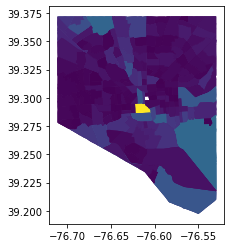

In [28]:
s = time.time()
q = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/final_data/baltimore_2017_2019_no_geo.csv'
qdf = pandas.read_csv(q)
qdf = qdf.set_index(['GEOID', 'year'], drop=True)


r = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/final_data/baltimore_2017_2019_shapefiles.shp'
rgdf = geopandas.read_file(r)
rgdf = rgdf.set_index(['GEOID', 'year'], drop=True)

gdf = geopandas.GeoDataFrame(data=pandas.concat((qdf, rgdf), axis=1), columns=pandas.concat((qdf, rgdf), axis=1).columns, crs=rgdf.crs, geometry='geometry')

e = time.time()
g = g + (e-s)

print('DONE! Total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

gdf.plot(column='amtLoans1_adj')